8. In the lab, a classification tree was applied to the `Carseats` data set after converting `Sales` into a qualitative response variable. 
Now we will seek to predict `Sales` using regression trees and related approaches, treating the response as a quantitative variable.

In [2]:
library("ISLR2")
library("skimr")
library("ggplot2")
library("tree")
library("randomForest")
library("gbm")
library("BART")

In [3]:
skim(Carseats)

Registered S3 method overwritten by 'cli':
  method     from
  print.tree tree



── Data Summary ────────────────────────
                           Values  
Name                       Carseats
Number of rows             400     
Number of columns          11      
_______________________            
Column type frequency:             
  factor                   3       
  numeric                  8       
________________________           
Group variables            None    

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 ShelveLoc             0             1 FALSE          3
2 Urban                 0             1 FALSE          2
3 US                    0             1 FALSE          2
  top_counts                
1 Med: 219, Bad: 96, Goo: 85
2 Yes: 282, No: 118         
3 Yes: 258, No: 142         

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   mean     sd    p0    p25    p50    p75
1 Sales   

(a) Split the data set into a training set and a test set.

In [31]:
set.seed(1)
train <- sample(1:nrow(Carseats), 200)

(b) Fit a regression tree to the training set. 
Plot the tree, and interpret the results. 
What test MSE do you obtain?

In [32]:
tree_fit <- tree(Sales ~ ., Carseats, subset = train)
tree_pred <- predict(tree_fit, Carseats[-train, ])
tree_pred_train <- predict(tree_fit, Carseats[train, ])

In [33]:
cat("Training error: ", mean((tree_pred_train - Carseats[train, "Sales"])^2), "\n")
cat("Testing error: ", mean((tree_pred - Carseats[-train, "Sales"])^2))

Training error:  1.971696 
Testing error:  4.922039

(c) Use cross-validation in order to determine the optimal level of tree complexity. 
Does pruning the tree improve the test MSE?


The function `cv.tree()` performs cross-validation in order to determine the optimal level of tree complexity; cost complexity pruning is used in order to select a sequence of trees for consideration. 
We use the argument `FUN = prune.tree` (or nothing) in order to indicate that we want the deviance to guide the cross-validation and pruning process. 
The `cv.tree()` function reports the number of terminal nodes of each tree considered (`size`) as well as the corresponding error rate and the value of the cost-complexity parameter used (`k`, which corresponds to $\alpha$ in (8.4)).

In [34]:
set.seed(1)
tree_cv <- cv.tree(tree_fit)
names(tree_cv)

[1] "size"   "dev"    "k"      "method"

In [35]:
tree_cv

$size
 [1] 18 17 16 15 14 13 12 11 10  8  7  6  5  4  3  2  1

$dev
 [1]  984.3936 1031.3372 1036.0021 1027.2166 1027.2166 1055.8168 1044.6955
 [8] 1061.0899 1061.0899 1225.5973 1221.3487 1219.0219 1231.6886 1337.3952
[15] 1300.0524 1338.3702 1605.0221

$k
 [1]      -Inf  16.99544  20.56322  25.01730  25.57104  28.01938  30.36962
 [8]  31.56747  31.80816  40.75445  44.44673  52.57126  76.21881  99.59459
[15] 116.69889 159.79501 337.60153

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"

We plot the error rate as a function of both `size` and `k`.

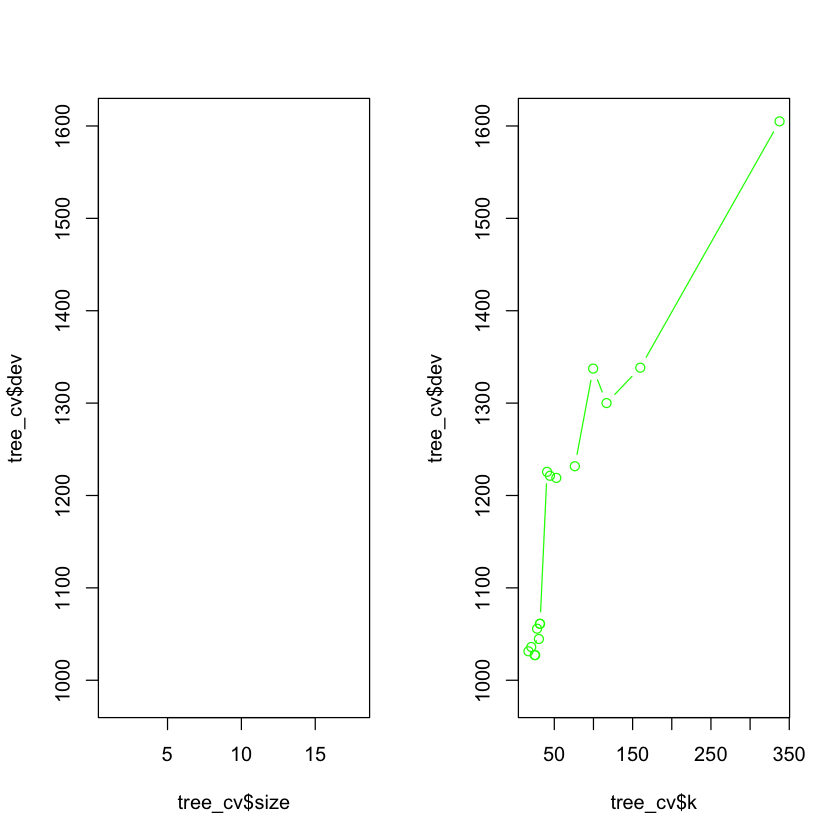

In [36]:
par(mfrow = c(1, 2))
plot(tree_cv$size, tree_cv$dev, type = "b", col = "white")
plot(tree_cv$k, tree_cv$dev, type = "b", col = "green")

Training error:  4.792956 
Testing error:  5.003119

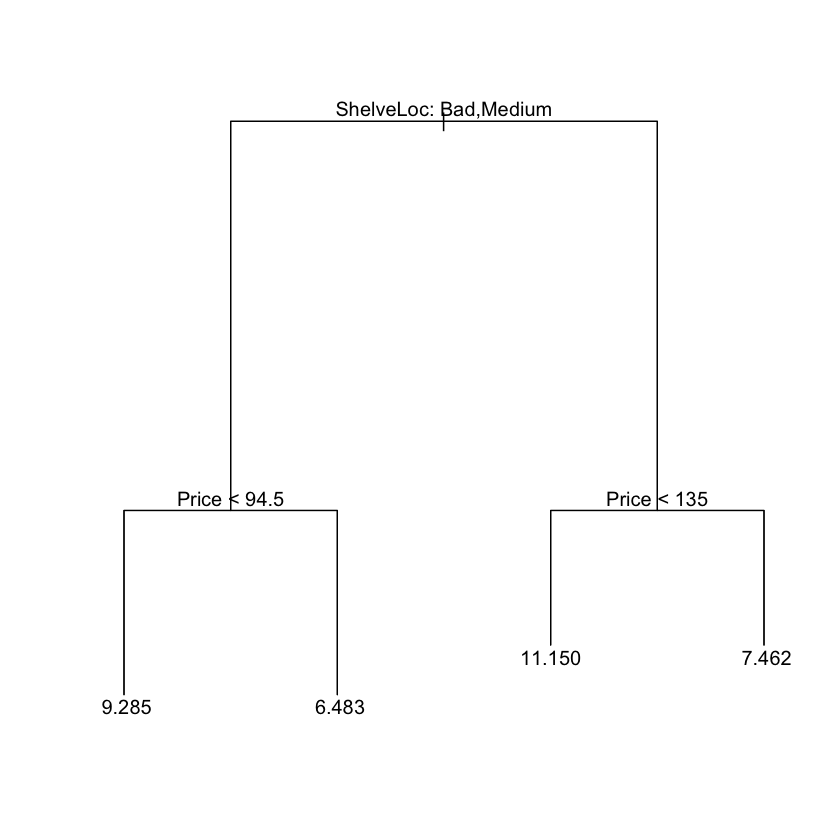

In [42]:
tree_prune <- prune.tree(tree_fit, best = 4)
plot(tree_prune)
text(tree_prune, pretty = 0)

tree_pred_prune <- predict(tree_prune, Carseats[-train, ])
tree_pred_prune_train <- predict(tree_prune, Carseats[train, ])
cat("Training error: ", mean((tree_pred_prune_train - Carseats[train, "Sales"])^2), "\n")
cat("Testing error: ", mean((tree_pred_prune - Carseats[-train, "Sales"])^2))

The pruning improves the variance of the model at a small expense of bias.

(d) Use the bagging approach in order to analyze this data. 
What test MSE do you obtain? 
Use the `importance()` function to determine which variables are most important.

In [43]:
set.seed(1)
bag_fit <- randomForest(
    Sales ~ .,
    data = Carseats,
    mtry = 10,
    importance = T,
    subset = train
)

bag_fit


Call:
 randomForest(formula = Sales ~ ., data = Carseats, mtry = 10,      importance = T, subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 10

          Mean of squared residuals: 2.889221
                    % Var explained: 63.26

Training error:  0.4921408 
Testing error:  2.605253

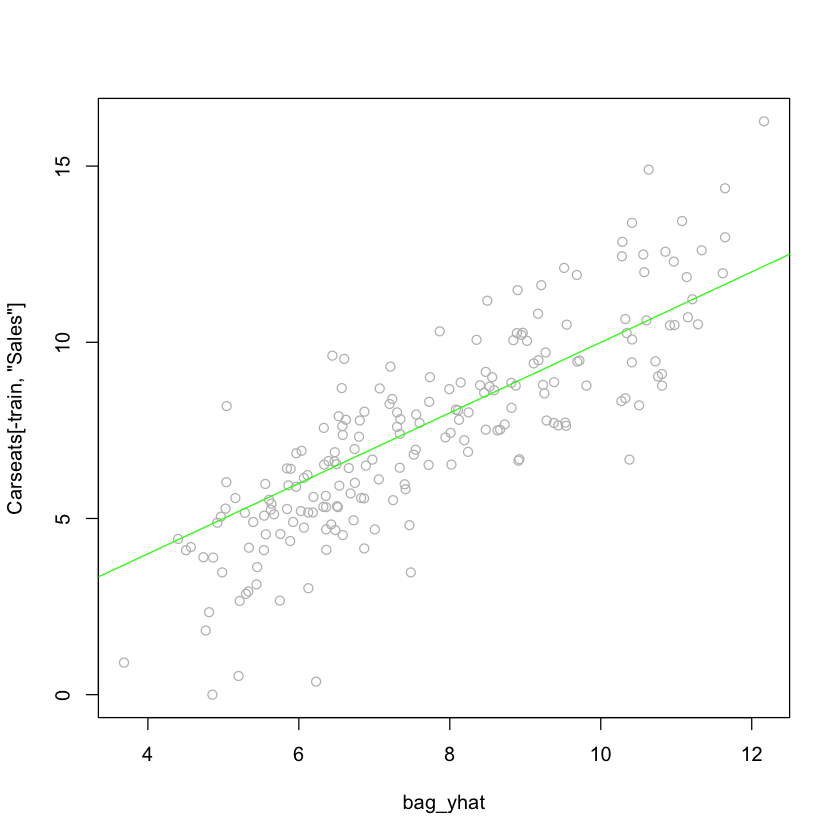

In [48]:
bag_yhat <- predict(bag_fit, newdata = Carseats[-train, ])
plot(bag_yhat, Carseats[-train, "Sales"], col = "grey")
abline(0, 1, col = "green")


bag_yhat_train <- predict(bag_fit, newdata = Carseats[train, ])
cat("Training error: ", mean((bag_yhat_train - Carseats[train, "Sales"])^2), "\n")
cat("Testing error: ", mean((bag_yhat - Carseats[-train, "Sales"])^2))

In [49]:
importance(bag_fit)

,%IncMSE,IncNodePurity
CompPrice,24.8888481,170.182937
Income,4.7121131,91.264880
Advertising,12.7692401,97.164338
Population,-1.8074075,58.244596
Price,56.3326252,502.903407
ShelveLoc,48.8886689,380.032715
Age,17.7275460,157.846774
Education,0.5962186,44.598731
Urban,0.1728373,9.822082
US,4.2172102,18.073863


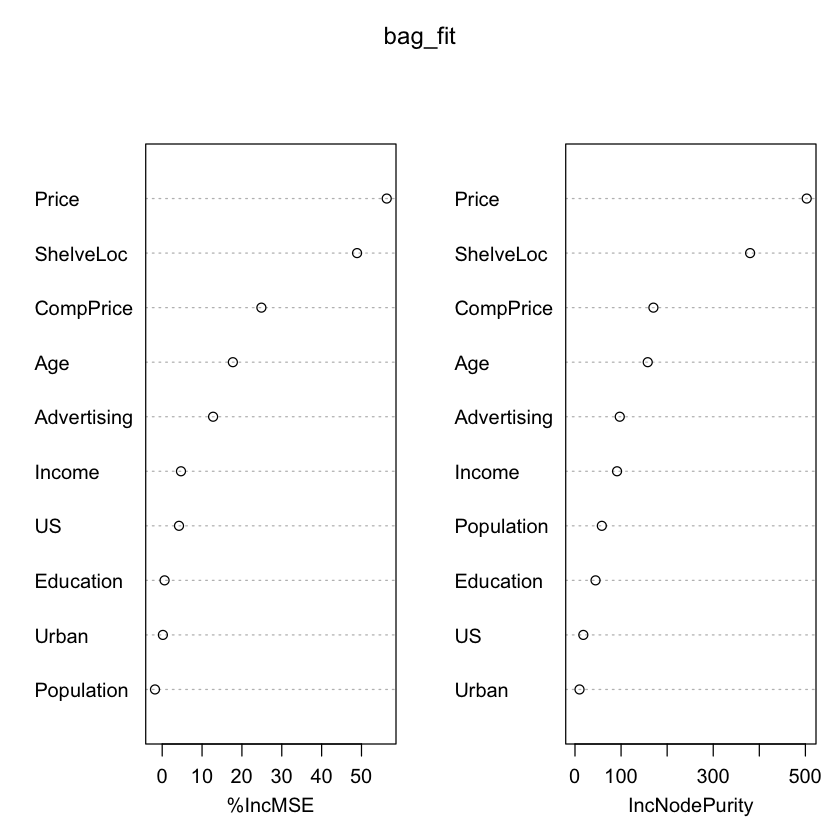

In [50]:
varImpPlot(bag_fit)

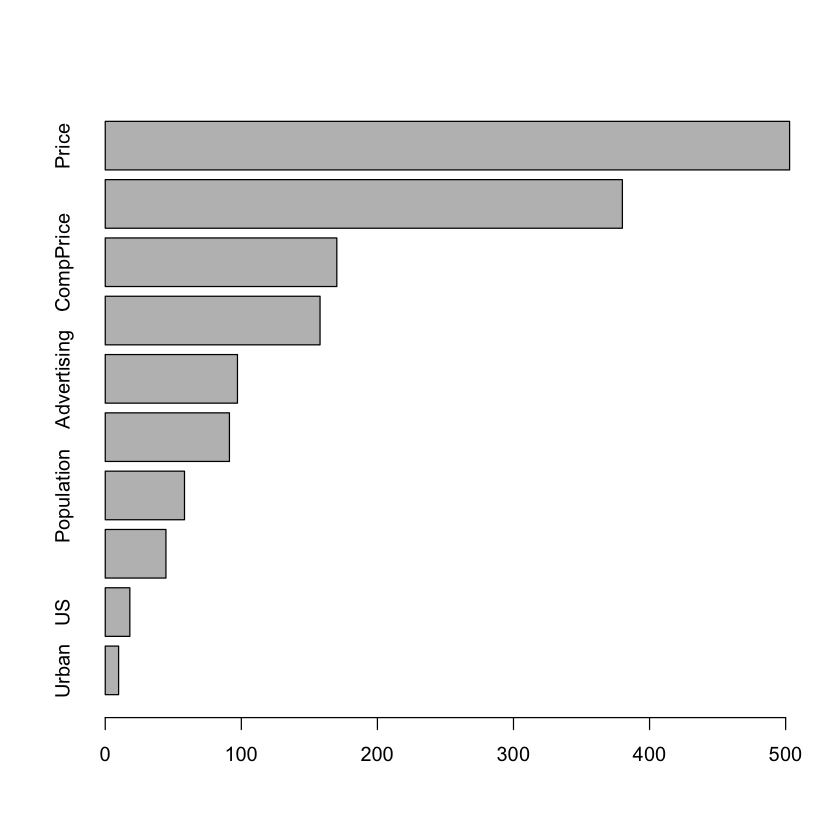

In [51]:
barplot(sort(importance(bag_fit)[, 2], decreasing = F), horiz = T)

(e) Use random forests to analyze this data. 
What test MSE do you obtain? 
Use the `importance()` function to determine which variables are most important. 
Describe the effect of `m`, the number of variables considered at each split, on the error rate obtained.

Growing a random forest proceeds in exactly the same way, except that we use a smaller value of the `mtry` argument. By default, `randomForest()` uses $p/3$ variables when building a random forest of regression trees, and $\sqrt{p}$ variables when building a random forest of classification trees. 
Here we use `mtry = 6`.

In [52]:
set.seed(1)
rf_fit <- randomForest(
    Sales ~ .,
    data = Carseats,
    mtry = 6,
    importance = T,
    subset = train
)

rf_fit


Call:
 randomForest(formula = Sales ~ ., data = Carseats, mtry = 6,      importance = T, subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 6

          Mean of squared residuals: 2.927653
                    % Var explained: 62.77

Training error:  0.5392916 
Testing error:  2.667767

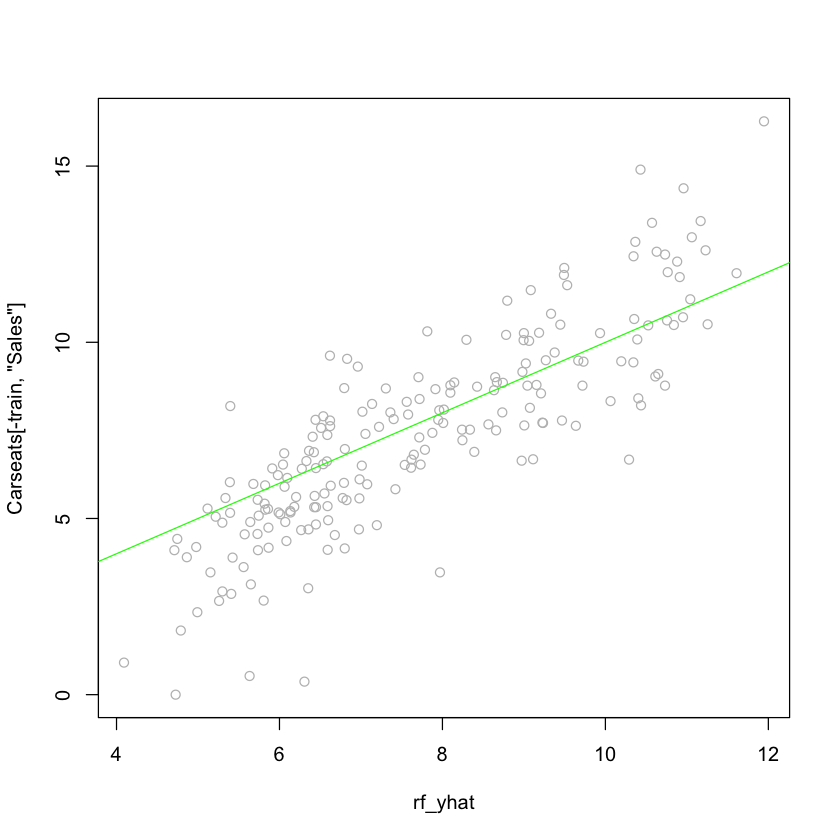

In [53]:
rf_yhat <- predict(rf_fit, newdata = Carseats[-train, ])
plot(rf_yhat, Carseats[-train, "Sales"], col = "grey")
abline(0, 1, col = "green")


rf_yhat_train <- predict(rf_fit, newdata = Carseats[train, ])
cat("Training error: ", mean((rf_yhat_train - Carseats[train, "Sales"])^2), "\n")
cat("Testing error: ", mean((rf_yhat - Carseats[-train, "Sales"])^2))

In [54]:
importance(rf_fit)

,%IncMSE,IncNodePurity
CompPrice,21.2810671,166.70772
Income,4.3025264,107.27167
Advertising,13.0238433,106.45246
Population,-1.4499135,69.25067
Price,48.7733335,458.46860
ShelveLoc,43.0085702,344.25186
Age,14.6008965,165.75483
Education,2.5172799,50.13234
Urban,0.1073247,10.78671
US,6.0111148,25.30629


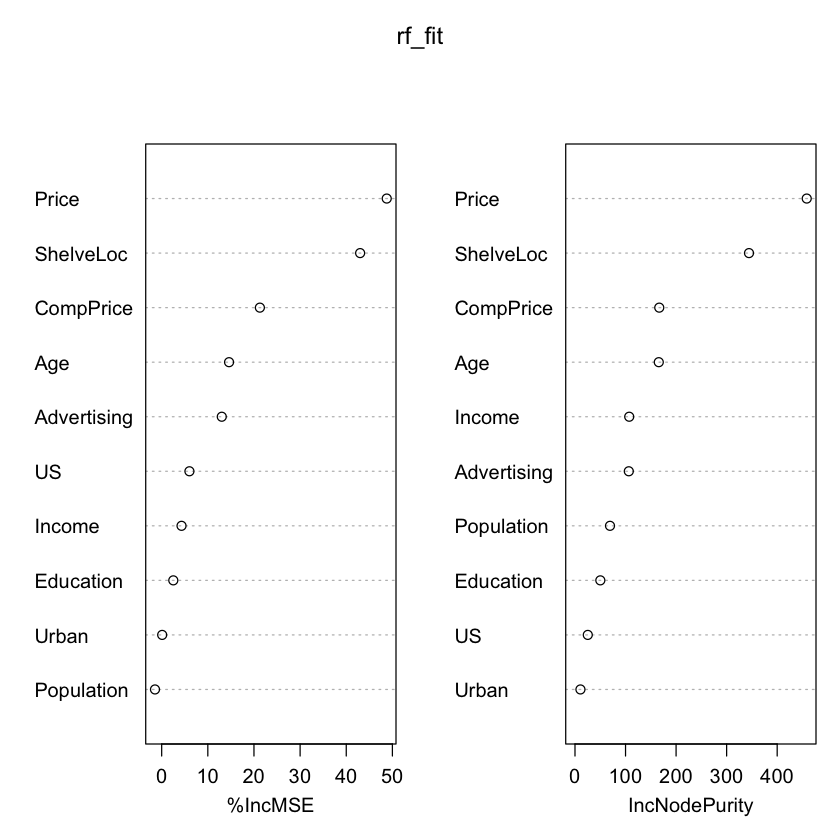

In [55]:
varImpPlot(rf_fit)

(f) Now analyze the data using BART, and report your results.

In [56]:
X <- Carseats[, names(Carseats) != "Sales"]
y <- Carseats[, "Sales"]
X_train <- X[train, ]
y_train <- y[train]
X_test <- X[-train, ]
y_test <- y[-train]

In [57]:
set.seed(1)
bart_fit <- gbart(X_train, y_train, x.test = X_test)

*****Calling gbart: type=1
*****Data:
data:n,p,np: 200, 14, 200
y1,yn: 2.781850, 1.091850
x1,x[n*p]: 107.000000, 1.000000
xp1,xp[np*p]: 111.000000, 1.000000
*****Number of Trees: 200
*****Number of Cut Points: 63 ... 1
*****burn,nd,thin: 100,1000,1
*****Prior:beta,alpha,tau,nu,lambda,offset: 2,0.95,0.273474,3,0.23074,7.57815
*****sigma: 1.088371
*****w (weights): 1.000000 ... 1.000000
*****Dirichlet:sparse,theta,omega,a,b,rho,augment: 0,0,1,0.5,1,14,0
*****printevery: 100

MCMC
done 0 (out of 1100)
done 100 (out of 1100)
done 200 (out of 1100)
done 300 (out of 1100)
done 400 (out of 1100)
done 500 (out of 1100)
done 600 (out of 1100)
done 700 (out of 1100)
done 800 (out of 1100)
done 900 (out of 1100)
done 1000 (out of 1100)
time: 2s
trcnt,tecnt: 1000,1000


In [58]:
bart_yhat_train <- bart_fit$yhat.train.mean
bart_yhat <- bart_fit$yhat.test.mean

cat("Training error: ", mean((bart_yhat_train - y_train)^2), "\n")
cat("Testing error: ", mean((bart_yhat - y_test)^2))

Training error:  0.5538728 
Testing error:  1.450842

On this data set, the test error of BART is lower than the test error of random forests and boosting.
Now we can check how many times each variable appeared in the collection of trees.

In [59]:
ord <- order(bart_fit$varcount.mean, decreasing = T)
print(bart_fit$varcount.mean[ord])

      Price   CompPrice  ShelveLoc2         US2  ShelveLoc1         US1 
     24.396      18.427      18.323      17.580      17.471      17.233 
  Education         Age      Urban1      Urban2      Income  Population 
     16.524      16.503      16.331      15.945      15.693      15.518 
 ShelveLoc3 Advertising 
     15.440      13.818 
